# Expected Goals (xG) Modeling in Football

## 🎯 Objective

The goal of this notebook is to build, evaluate, and compare various models for estimating the probability that a shot results in a goal — commonly referred to as *expected goals (xG)*. The analysis is based on real shot-level data and incorporates both contextual and spatial features.

---

## ⚽ Dataset Overview

The original dataset has been cleaned and split into four meaningful subsets:

- **OpenPlay_Foot**: Shots with the foot during open play
- **OpenPlay_Head**: Headers during open play
- **SetPiece_Foot**: Shots with the foot from set pieces (e.g., free kicks, corners)
- **SetPiece_Head**: Headers from set pieces

For each shot, the following engineered features were computed:

- **Distance** from the goal (based on normalized pitch coordinates)
- **Shot angle** relative to the goal
- **Minute** of the match when the shot was taken
- **Last action** before the shot (pass, rebound, dribble, etc.)
- **Home/Away indicator** (`h_a`)
- **Weak foot indicator** (`is_weakfoot`) – used only for footed shots

---

## 🧠 Modeling Approach

Each subset is modeled independently using the following classification algorithms:

- Logistic Regression
- Linear Discriminant Analysis (LDA)
- Random Forest
- Bagging (with logistic regression as base estimator
- Dense Feed Forward Neural Network

The training pipeline includes:

- Handling of categorical features via one-hot encoding
- Train/test splitting with stratification
- Performance evaluation using standard classification metrics

---

## 📊 Evaluation Metrics

Each model is evaluated on the test set using:

- **AUC (Area Under the ROC Curve)**
- **Brier Score** (calibration)
- **Precision, Recall, F1-score** (from classification report)

These metrics allow us to assess both the discriminatory power and the calibration of the predicted probabilities.

---

## 📝 Final Goal

To identify which modeling approaches perform best in different tactical shot scenarios, and to explore how contextual and spatial features (e.g., weak foot, distance, angle) impact goal probability estimation.

This work can support tactical analysis, player evaluation, and simulation models in football analytics.


In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, classification_report, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

import shap

2025-07-21 14:15:04.195946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753107304.379738      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753107304.433271      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/shots-dataset-for-footballsoccer/shots_dataset_cleaned.csv')

In [4]:
open_play_df = df[df['situation'] == 'OpenPlay']
set_piece_df = df[~df['situation'].isin(['OpenPlay', 'Penalty'])]

In [5]:
open_play_foot = open_play_df[open_play_df['shotType'].isin(['RightFoot', 'LeftFoot'])].copy()
open_play_head = open_play_df[open_play_df['shotType'] == 'Head'].copy()
set_piece_foot = set_piece_df[set_piece_df['shotType'].isin(['RightFoot', 'LeftFoot'])].copy()
set_piece_head = set_piece_df[set_piece_df['shotType'] == 'Head'].copy()

In [6]:
open_play_foot

,Unnamed: 0,player,id,minute,result,X,Y,xG Understat,h_a,player_id,...,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,Preffered_Foot,lega
0,1,Aaron Connolly,427269,51,0,0.913,0.536,0.562996,h,7991,...,16391,Brighton,Watford,2,0,2021-08-21 16:30:00,NaN,NaN,RightFoot,Premier League
2,3,Aaron Connolly,338614,91,0,0.797,0.377,0.030847,h,7991,...,11815,Brighton,Sheffield United,0,1,2019-12-21 15:00:00,NaN,NaN,RightFoot,Premier League
3,4,Aaron Connolly,403235,49,0,0.847,0.382,0.124788,a,7991,...,14656,Burnley,Brighton,1,1,2021-02-06 15:00:00,Yves Bissouma,Tackle,RightFoot,Premier League
4,5,Aaron Connolly,373666,71,0,0.870,0.472,0.103834,a,7991,...,12022,Burnley,Brighton,1,2,2020-07-26 15:00:00,Alexis Mac Allister,Rebound,RightFoot,Premier League
5,6,Aaron Connolly,403231,41,0,0.785,0.511,0.045065,a,7991,...,14656,Burnley,Brighton,1,1,2021-02-06 15:00:00,Pascal Groß,Pass,RightFoot,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442584,459752,Zuriko Davitashvili,424880,42,0,0.849,0.625,0.075317,h,7652,...,16145,Arsenal Tula,Rubin Kazan,0,3,2021-07-30 16:00:00,Danil Stepanov,Pass,RightFoot,Russian PL
442585,459753,Zuriko Davitashvili,435969,58,0,0.897,0.468,0.138103,h,7652,...,16221,Arsenal Tula,Zenit St. Petersburg,2,1,2021-10-16 11:00:00,Kings Kangwa,Pass,RightFoot,Russian PL
442586,459754,Zuriko Davitashvili,440079,55,0,0.769,0.469,0.027447,h,7652,...,16234,Arsenal Tula,PFC Sochi,1,2,2021-10-31 13:30:00,NaN,NaN,RightFoot,Russian PL
442587,459755,Zuriko Davitashvili,307776,81,0,0.815,0.649,0.067869,h,7652,...,11046,Rubin Kazan,FK Akhmat,1,0,2019-07-29 17:00:00,Danil Stepanov,Pass,RightFoot,Russian PL


In [7]:
open_play_head

,Unnamed: 0,player,id,minute,result,X,Y,xG Understat,h_a,player_id,...,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,Preffered_Foot,lega
15,16,Aaron Connolly,394366,81,0,0.970,0.542,0.508554,h,7991,...,14565,Brighton,Sheffield United,1,1,2020-12-20 12:00:00,Alireza Jahanbakhsh,Cross,RightFoot,Premier League
49,50,Aaron Connolly,317278,93,0,0.868,0.507,0.035983,h,7991,...,11685,Brighton,Burnley,1,1,2019-09-14 14:00:00,Pascal Groß,Chipped,RightFoot,Premier League
61,62,Aaron Cresswell,17529,35,0,0.932,0.596,0.039814,h,534,...,4606,West Ham,Swansea,3,1,2014-12-07 13:30:00,Stewart Downing,Chipped,LeftFoot,Premier League
65,66,Aaron Cresswell,194108,44,0,0.906,0.664,0.015231,h,534,...,7360,West Ham,Crystal Palace,1,1,2018-01-30 19:45:00,Sam Byram,Aerial,LeftFoot,Premier League
75,76,Aaron Cresswell,274375,28,0,0.889,0.534,0.040844,h,534,...,9407,West Ham,Arsenal,1,0,2019-01-12 12:30:00,NaN,NaN,LeftFoot,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442490,459658,Zuriko Davitashvili,384995,4,0,0.884,0.630,0.016722,h,7652,...,14326,FC Rotor Volgograd,CSKA Moscow,0,1,2020-11-01 13:30:00,Flamarion Junior,Aerial,RightFoot,Russian PL
442493,459661,Zuriko Davitashvili,323960,69,0,0.915,0.392,0.035421,h,7652,...,11112,Rubin Kazan,FC Tambov,2,1,2019-10-05 14:30:00,Alexander Tashaev,Aerial,RightFoot,Russian PL
442507,459675,Zuriko Davitashvili,446531,23,0,0.904,0.386,0.026653,a,7652,...,16271,Khimki,Arsenal Tula,1,2,2021-12-05 11:00:00,Igor Smolnikov,Cross,RightFoot,Russian PL
442531,459699,Zuriko Davitashvili,330136,31,0,0.888,0.646,0.011853,a,7652,...,11136,Krylya Sovetov Samara,Rubin Kazan,0,0,2019-11-04 13:30:00,Igor Konovalov,Aerial,RightFoot,Russian PL


In [8]:
set_piece_foot

,Unnamed: 0,player,id,minute,result,X,Y,xG Understat,h_a,player_id,...,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,Preffered_Foot,lega
16,17,Aaron Connolly,351416,79,0,0.925,0.481,0.560738,h,7991,...,11845,Brighton,Chelsea,1,1,2020-01-01 12:30:00,Alireza Jahanbakhsh,Rebound,RightFoot,Premier League
27,28,Aaron Connolly,368503,2,0,0.865,0.705,0.031402,a,7991,...,11969,Norwich,Brighton,0,1,2020-07-04 11:30:00,NaN,NaN,RightFoot,Premier League
45,46,Aaron Connolly,378648,24,0,0.885,0.330,0.032655,h,7991,...,14106,Brighton,Manchester United,2,3,2020-09-26 11:30:00,Neal Maupay,Chipped,RightFoot,Premier League
53,54,Aaron Connolly,366073,2,0,0.864,0.418,0.066627,a,7991,...,11945,Leicester,Brighton,0,0,2020-06-23 17:00:00,NaN,Rebound,RightFoot,Premier League
62,63,Aaron Cresswell,405039,29,0,0.781,0.250,0.045748,h,534,...,14674,West Ham,Sheffield United,3,0,2021-02-15 18:00:00,NaN,Standard,LeftFoot,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442566,459734,Zuriko Davitashvili,431879,75,0,0.786,0.779,0.039379,a,7652,...,16197,Nizhny Novgorod,Arsenal Tula,2,3,2021-09-19 13:30:00,NaN,Standard,RightFoot,Russian PL
442574,459742,Zuriko Davitashvili,375907,91,0,0.802,0.663,0.076886,h,7652,...,14033,FC Rotor Volgograd,Spartak Moscow,0,1,2020-08-26 15:30:00,NaN,Standard,RightFoot,Russian PL
442575,459743,Zuriko Davitashvili,323946,31,1,0.902,0.495,0.270471,h,7652,...,11112,Rubin Kazan,FC Tambov,2,1,2019-10-05 14:30:00,Vyacheslav Podberezkin,TakeOn,RightFoot,Russian PL
442579,459747,Zuriko Davitashvili,307949,79,0,0.821,0.673,0.021622,h,7652,...,11052,Rubin Kazan,CSKA Moscow,0,1,2019-08-04 17:00:00,NaN,NaN,RightFoot,Russian PL


In [9]:
set_piece_head

,Unnamed: 0,player,id,minute,result,X,Y,xG Understat,h_a,player_id,...,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,Preffered_Foot,lega
1,2,Aaron Connolly,329180,49,0,0.944,0.383,0.014080,h,7991,...,11746,Brighton,Norwich,2,0,2019-11-02 15:00:00,Pascal Groß,Aerial,RightFoot,Premier League
54,55,Aaron Connolly,323890,9,0,0.879,0.395,0.015313,h,7991,...,11713,Brighton,Tottenham,3,0,2019-10-05 12:30:00,Pascal Groß,OffsidePass,RightFoot,Premier League
58,59,Aaron Connolly,331316,40,0,0.919,0.504,0.368687,a,7991,...,11761,Manchester United,Brighton,3,1,2019-11-10 14:00:00,Leandro Trossard,Aerial,RightFoot,Premier League
107,108,Aaron Cresswell,352250,14,0,0.929,0.594,0.020945,a,534,...,11876,Leicester,West Ham,4,1,2020-01-22 19:30:00,NaN,Aerial,LeftFoot,Premier League
249,250,Aaron Hunt,28970,75,0,0.949,0.621,0.032755,a,174,...,5263,Eintracht Frankfurt,Wolfsburg,1,1,2015-02-03 19:00:00,Naldo,Rebound,LeftFoot,Bundesliga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442483,459650,Zouhair Feddal,189479,60,0,0.881,0.433,0.032676,h,2388,...,8074,Real Betis,Barcelona,0,5,2018-01-21 19:45:00,Andrés Guardado,Cross,LeftFoot,Liga
442484,459651,Zouhair Feddal,92574,77,0,0.900,0.548,0.020251,a,2388,...,1758,Malaga,Levante,3,1,2016-05-02 22:30:00,Verza,Aerial,LeftFoot,Liga
442489,459657,Zuriko Davitashvili,323955,59,0,0.920,0.422,0.033390,h,7652,...,11112,Rubin Kazan,FC Tambov,2,1,2019-10-05 14:30:00,Igor Konovalov,Aerial,RightFoot,Russian PL
442590,459758,Zvonimir Sarlija,331248,65,0,0.902,0.480,0.021030,a,7646,...,11144,PFC Sochi,CSKA Moscow,2,3,2019-11-10 13:30:00,Ivan Oblyakov,Aerial,RightFoot,Russian PL


In [10]:
def compute_is_weakfoot(shot_type_series, preferred_foot_series):
    return np.where(
        (preferred_foot_series == 'both') | (shot_type_series == preferred_foot_series),
        'No',
        'Yes'
    )

open_play_foot['is_weakfoot'] = compute_is_weakfoot(open_play_foot['shotType'], open_play_foot['Preffered_Foot'])
set_piece_foot['is_weakfoot'] = compute_is_weakfoot(set_piece_foot['shotType'], set_piece_foot['Preffered_Foot'])

In [11]:
df = open_play_foot.copy()
df['goal'] = (df['result'] == 1).astype(int)

In [12]:
foot_datasets = {
    'OpenPlay_Foot': open_play_foot.copy(),
    'SetPiece_Foot': set_piece_foot.copy()
}
head_datasets = {
    'OpenPlay_Head': open_play_head.copy(),
    'SetPiece_Head': set_piece_head.copy()
}

results = {}
best_rf_params = None  # iperparametri da trasferire ai dataset Head

def run_models(name, df, use_weakfoot, rf_params=None, autotune_rf=False):
    df = df.copy()
    df['goal'] = (df['result'] == 1).astype(int)

    goal_x, goal_y = 1.0, 0.5
    df['distance'] = np.sqrt((df['X'] - goal_x)**2 + (df['Y'] - goal_y)**2)
    df['angle'] = np.arctan2(7.32 * df['X'], (df['X']**2 + (df['Y'] - 0.5)**2 - (7.32 / 2)**2))
    df['angle'] = df['angle'].apply(lambda x: x if x > 0 else 0)

    features = ['minute', 'lastAction', 'h_a', 'distance', 'angle']
    if use_weakfoot:
        features.append('is_weakfoot')

    X = df[features]
    y = df['goal']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    categorical_features = ['lastAction', 'h_a']
    if use_weakfoot:
        categorical_features.append('is_weakfoot')

    numeric_features = ['minute', 'distance', 'angle']

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

    model_results = {}

    # Modelli senza tuning
    models = {
        'Logit': LogisticRegression(max_iter=1000),
        'LDA': LinearDiscriminantAnalysis(),
        'Bagging': BaggingClassifier(estimator=LogisticRegression(max_iter=1000), n_estimators=50, random_state=42)

    }

    for model_name, model in models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]

        model_results[model_name] = {
            'AUC': roc_auc_score(y_test, y_proba),
            'Brier': brier_score_loss(y_test, y_proba),
            'Report': classification_report(y_test, y_pred, output_dict=True),
            'ConfusionMatrix': confusion_matrix(y_test, y_pred).tolist()
        }

    # Random Forest ---
    if autotune_rf:
        # tuning RF con GridSearch
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__max_features': ['sqrt', 'log2']
        }
        pipe_rf = Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestClassifier(random_state=42))
        ])
        grid = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        rf = best_model.named_steps['model']
        used_params = rf.get_params()
    else:
        rf = RandomForestClassifier(**rf_params)
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', rf)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]

    if autotune_rf:
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        model_results['RandomForest'] = {
            'AUC': roc_auc_score(y_test, y_proba),
            'Brier': brier_score_loss(y_test, y_proba),
            'Report': classification_report(y_test, y_pred, output_dict=True),
            'ConfusionMatrix': confusion_matrix(y_test, y_pred).tolist()
        }
        return model_results, rf.get_params()
    else:
        model_results['RandomForest'] = {
            'AUC': roc_auc_score(y_test, y_proba),
            'Brier': brier_score_loss(y_test, y_proba),
            'Report': classification_report(y_test, y_pred, output_dict=True),
            'ConfusionMatrix': confusion_matrix(y_test, y_pred).tolist()
        }
        return model_results

# FOOT
for name, df in foot_datasets.items():
    model_results, best_rf_params = run_models(name, df, use_weakfoot=True, autotune_rf=True)
    results[name] = model_results

# HEAD
for name, df in head_datasets.items():
    model_results = run_models(name, df, use_weakfoot=False, rf_params=best_rf_params, autotune_rf=False)
    results[name] = model_results

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

In [13]:
for dataset, models in results.items():
    print(f"--- {dataset} ---")
    for model_name, metrics in models.items():
        print(f"{model_name}: AUC = {metrics['AUC']:.3f}")


--- OpenPlay_Foot ---
Logit: AUC = 0.798
LDA: AUC = 0.796
Bagging: AUC = 0.798
RandomForest: AUC = 0.829
--- SetPiece_Foot ---
Logit: AUC = 0.764
LDA: AUC = 0.759
Bagging: AUC = 0.764
RandomForest: AUC = 0.828
--- OpenPlay_Head ---
Logit: AUC = 0.759
LDA: AUC = 0.758
Bagging: AUC = 0.759
RandomForest: AUC = 0.790
--- SetPiece_Head ---
Logit: AUC = 0.772
LDA: AUC = 0.765
Bagging: AUC = 0.772
RandomForest: AUC = 0.821


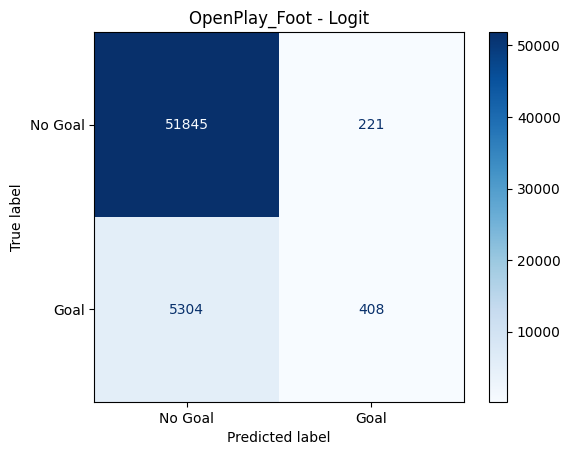

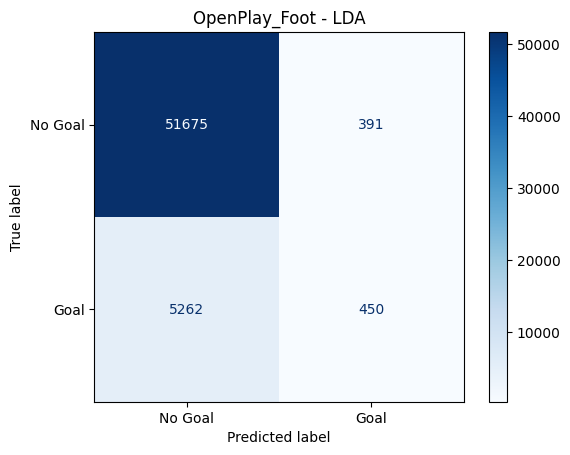

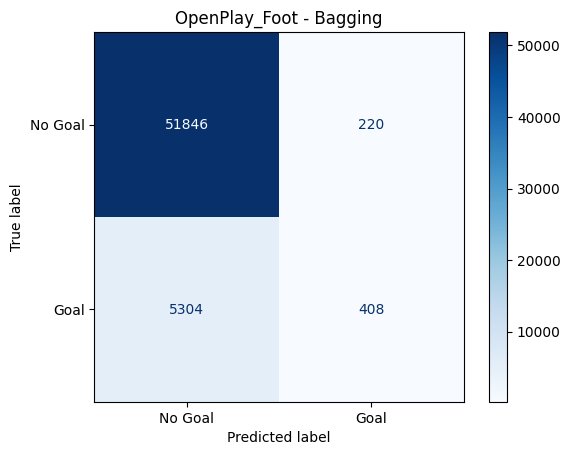

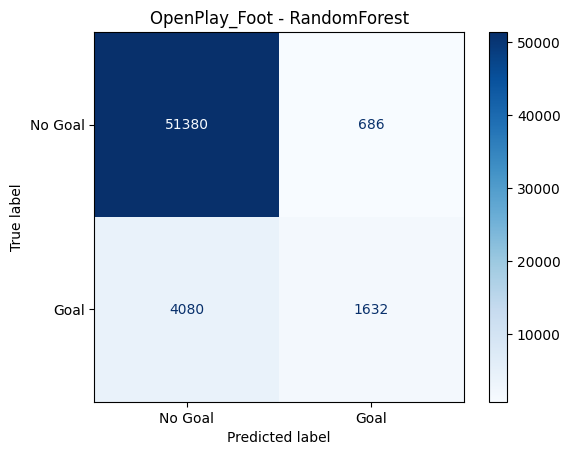

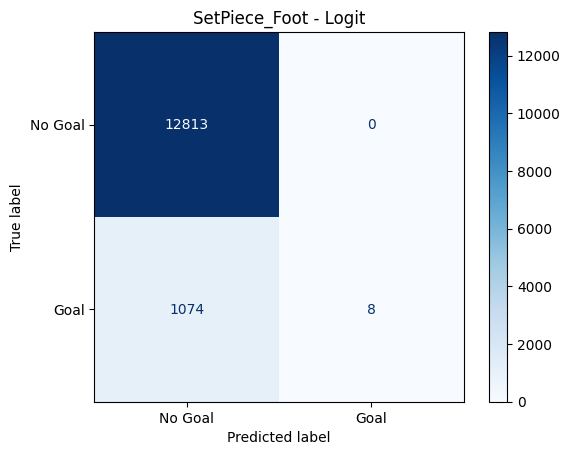

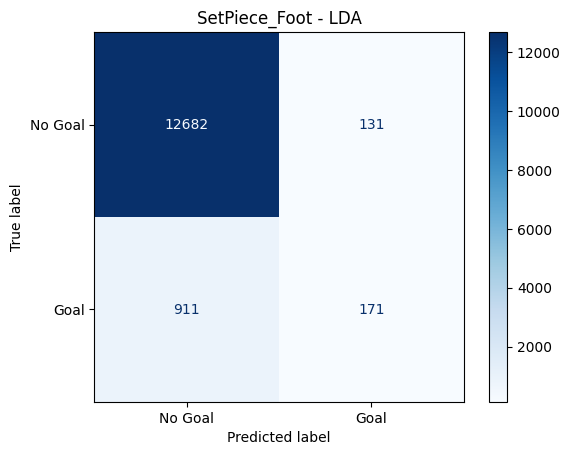

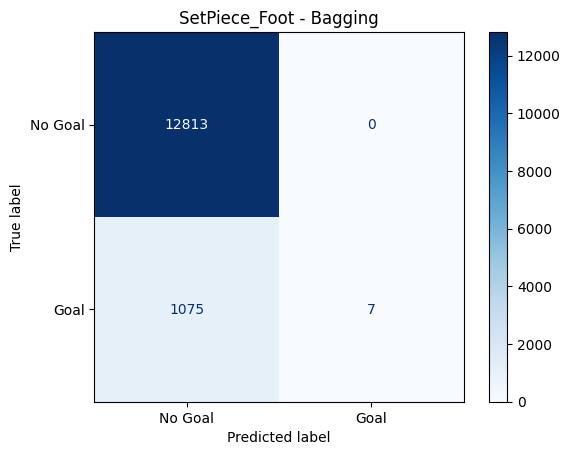

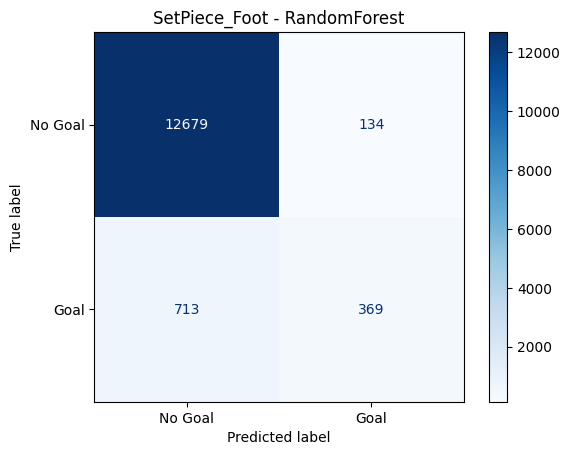

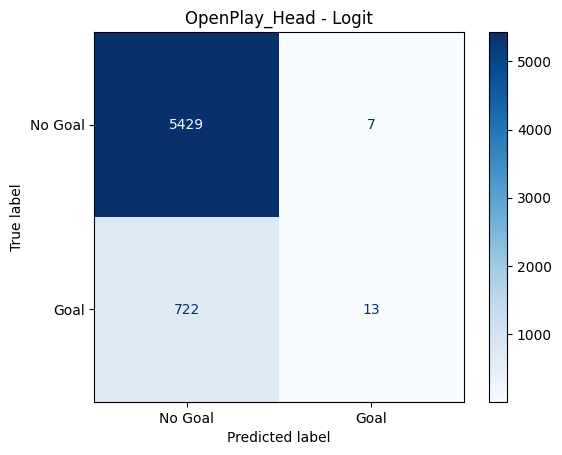

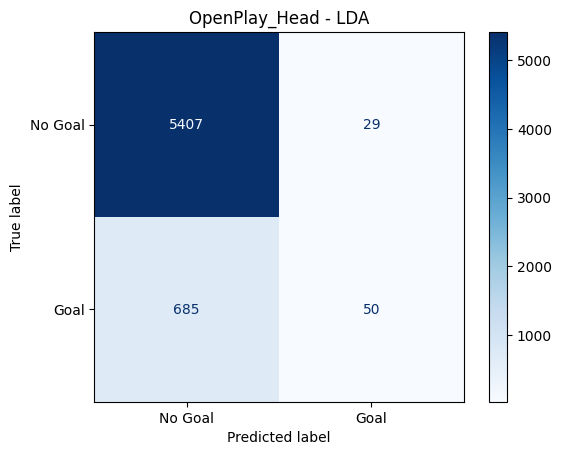

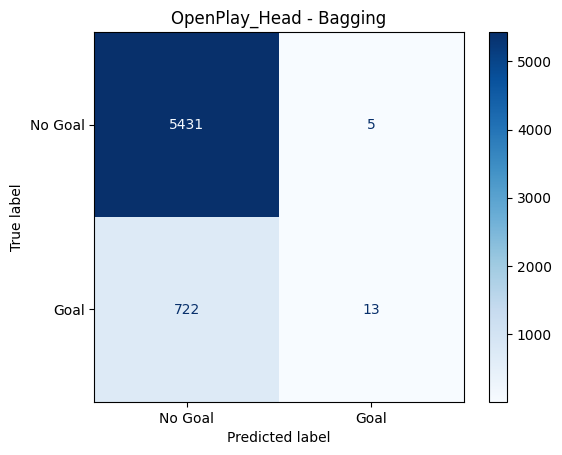

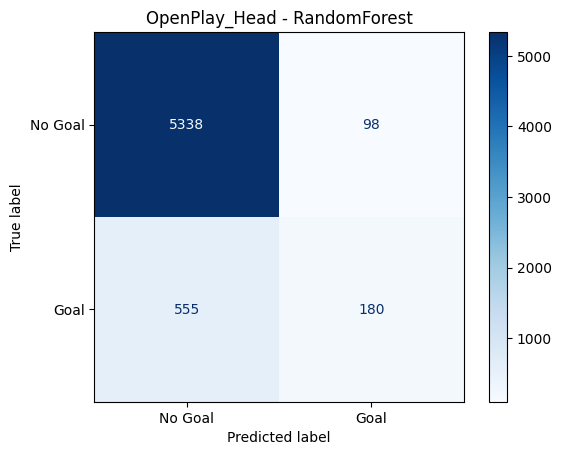

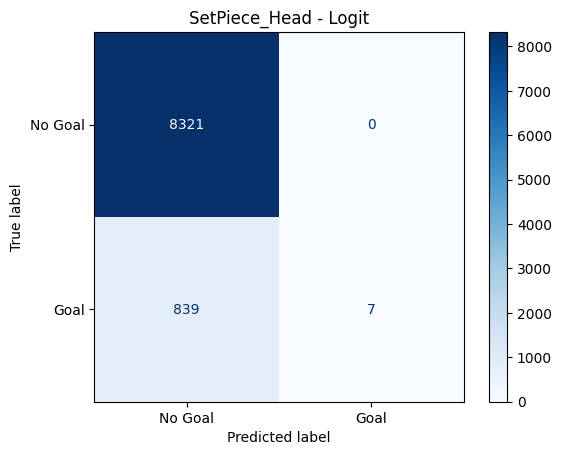

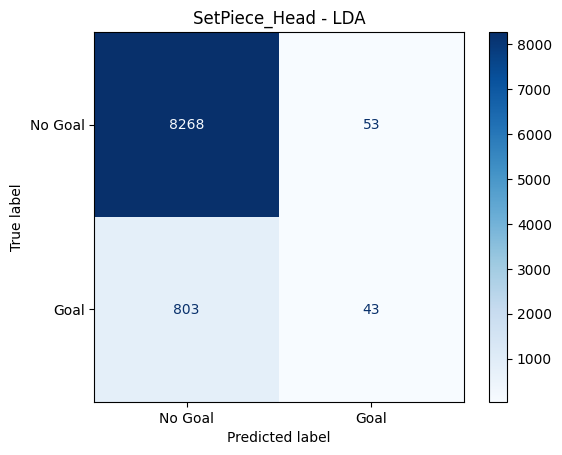

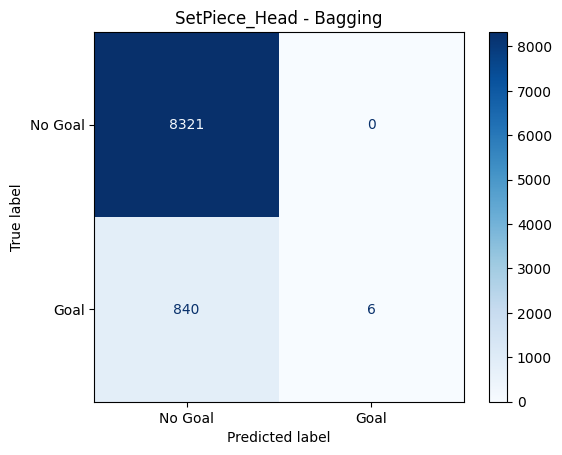

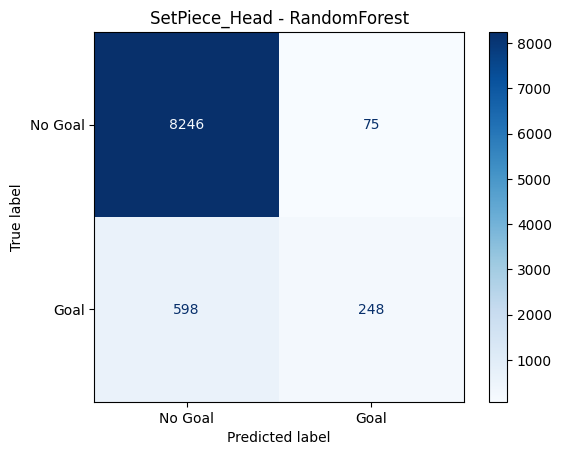

In [14]:
def plot_confusion_matrices(results):
    for dataset_name, models in results.items():
        for model_name, metrics in models.items():
            cm = np.array(metrics['ConfusionMatrix'])

            disp = ConfusionMatrixDisplay(
                confusion_matrix=cm,
                display_labels=['No Goal', 'Goal']
            )
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"{dataset_name} - {model_name}")
            plt.grid(False)
            plt.show()

plot_confusion_matrices(results)

In [15]:
def update_results_with_ytest_yproba(results, datasets_dict, best_rf_params, use_weakfoot_datasets):
    for dataset_name, df in datasets_dict.items():
        df = df.copy()
        df['goal'] = (df['result'] == 1).astype(int)

        goal_x, goal_y = 1.0, 0.5
        df['distance'] = np.sqrt((df['X'] - goal_x)**2 + (df['Y'] - goal_y)**2)
        df['angle'] = np.arctan2(7.32 * df['X'], (df['X']**2 + (df['Y'] - 0.5)**2 - (7.32 / 2)**2))
        df['angle'] = df['angle'].apply(lambda x: x if x > 0 else 0)

        features = ['minute', 'lastAction', 'h_a', 'distance', 'angle']
        if dataset_name in use_weakfoot_datasets:
            features.append('is_weakfoot')

        X = df[features]
        y = df['goal']
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

        categorical_features = ['lastAction', 'h_a']
        if dataset_name in use_weakfoot_datasets:
            categorical_features.append('is_weakfoot')

        numeric_features = ['minute', 'distance', 'angle']

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer([
            ('cat', categorical_transformer, categorical_features)
        ], remainder='passthrough')

        models = {
            'Logit': LogisticRegression(max_iter=1000),
            'LDA': LinearDiscriminantAnalysis(),
            'Bagging': BaggingClassifier(estimator=LogisticRegression(max_iter=1000), n_estimators=50, random_state=42),
            'RandomForest': RandomForestClassifier(**best_rf_params)
        }

        for model_name, model in models.items():
            pipe = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model)
            ])
            pipe.fit(X_train, y_train)
            y_proba = pipe.predict_proba(X_test)[:, 1]
            results[dataset_name][model_name]['y_test'] = y_test.tolist()
            results[dataset_name][model_name]['y_proba'] = y_proba.tolist()

In [16]:
datasets_dict = {**foot_datasets, **head_datasets}
use_weakfoot_datasets = ['OpenPlay_Foot', 'SetPiece_Foot']

update_results_with_ytest_yproba(results, datasets_dict, best_rf_params, use_weakfoot_datasets)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

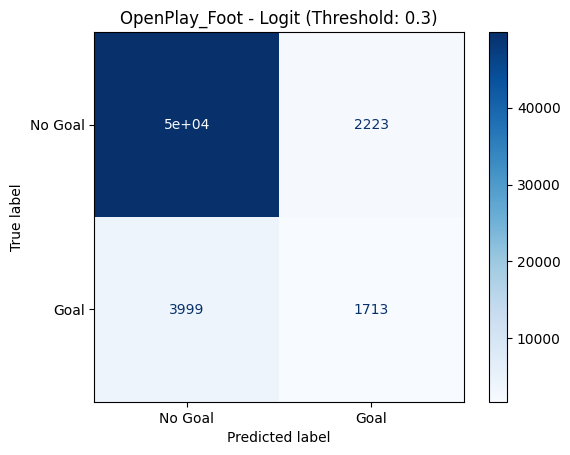

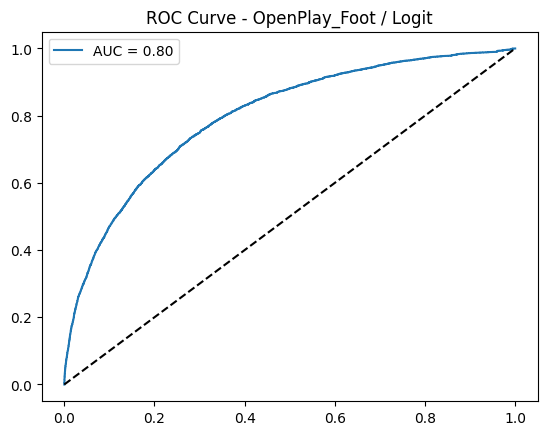

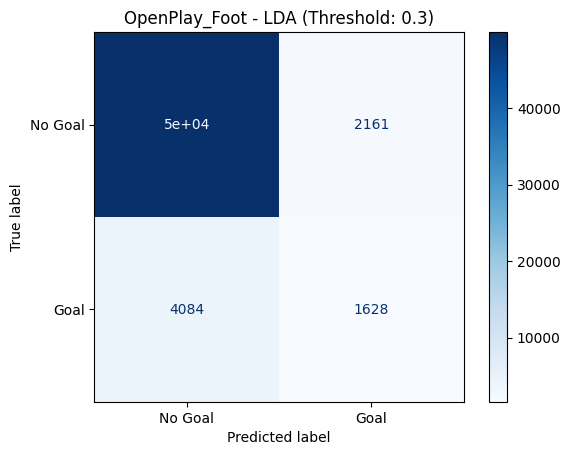

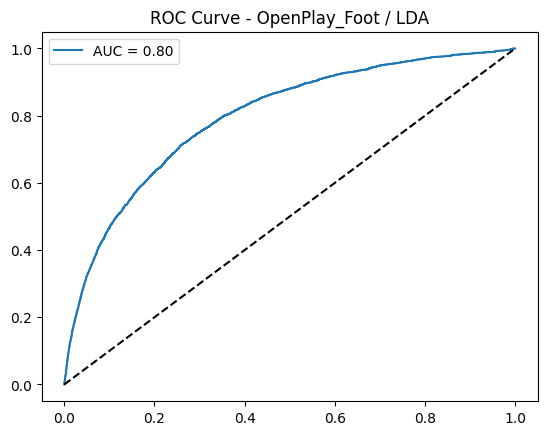

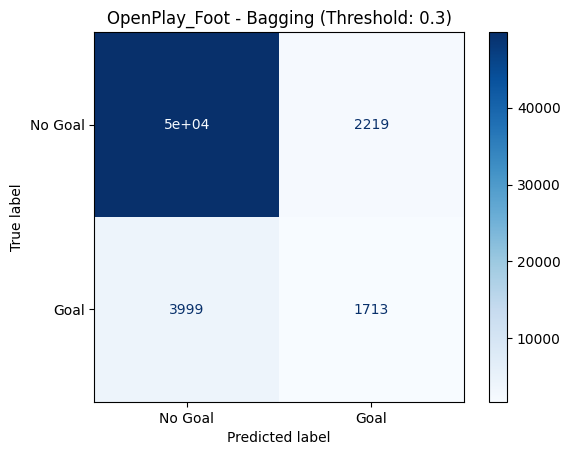

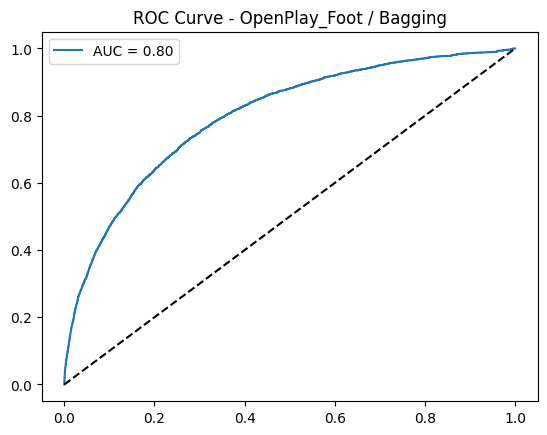

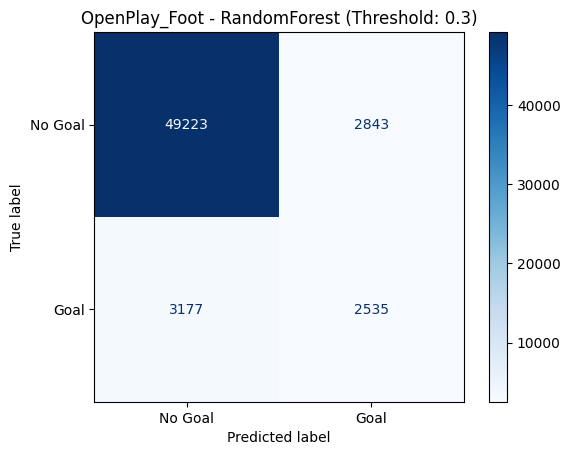

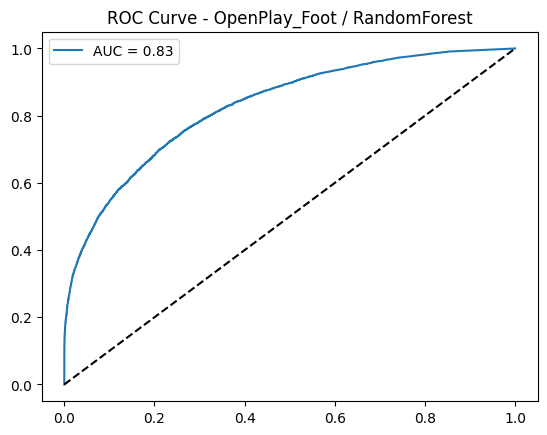

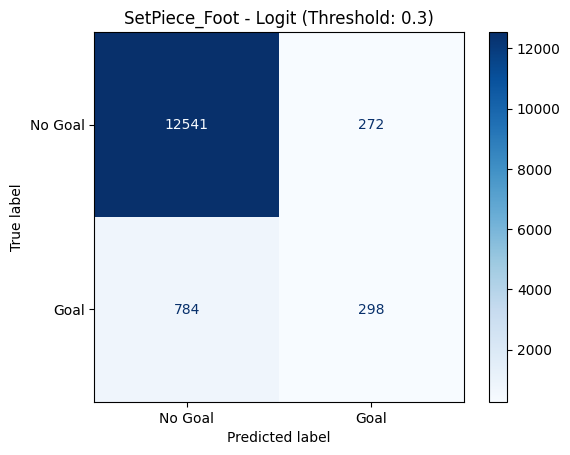

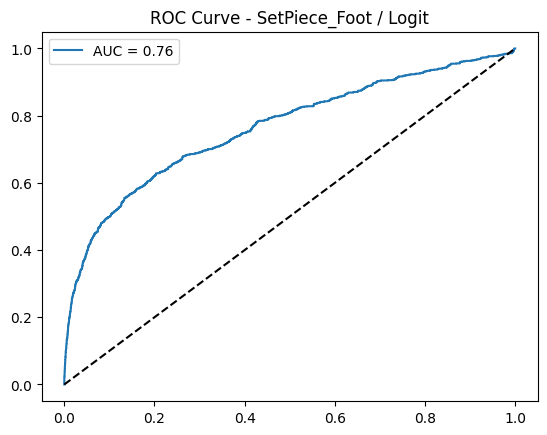

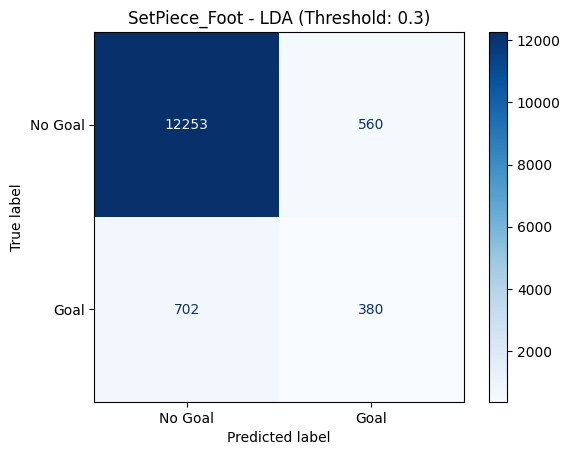

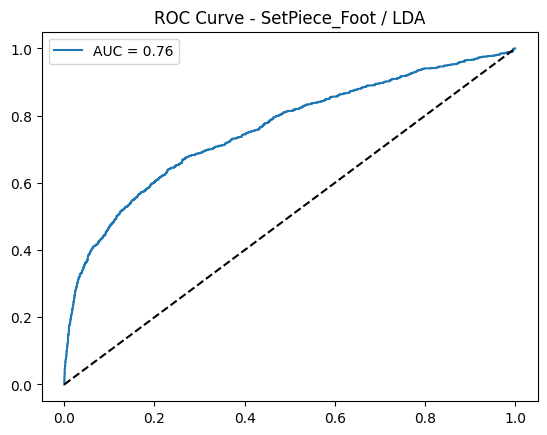

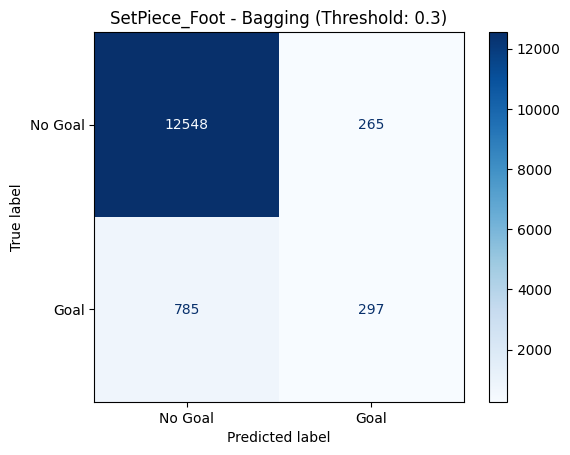

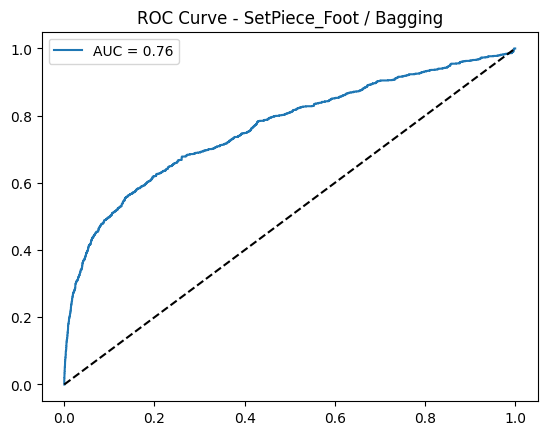

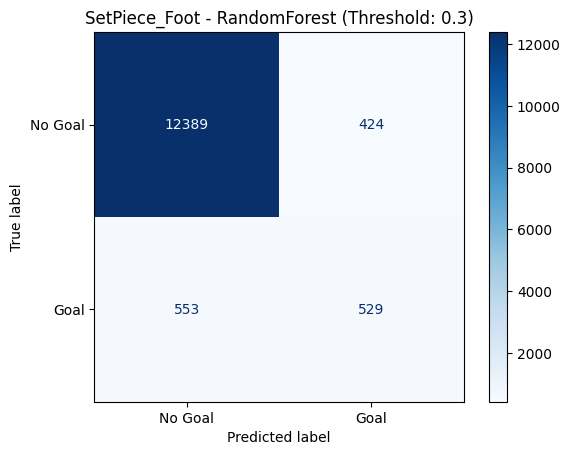

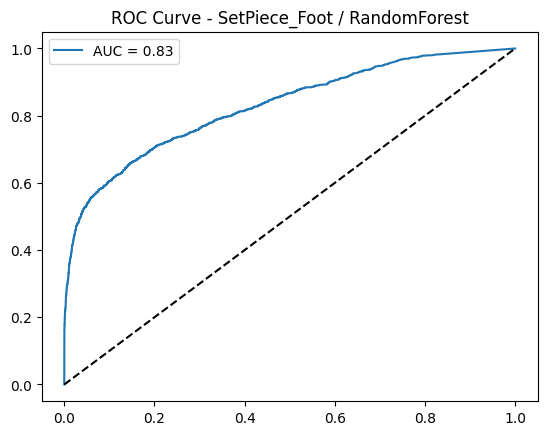

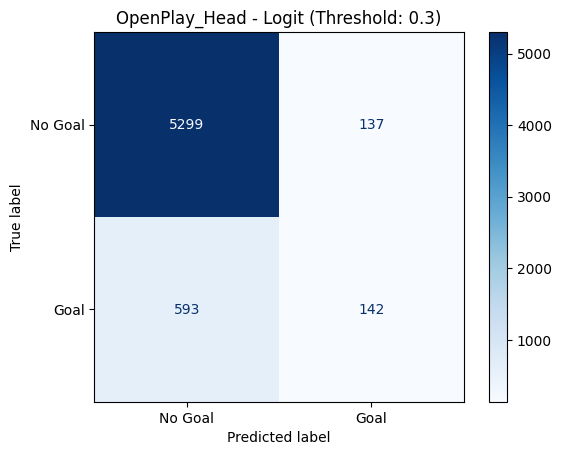

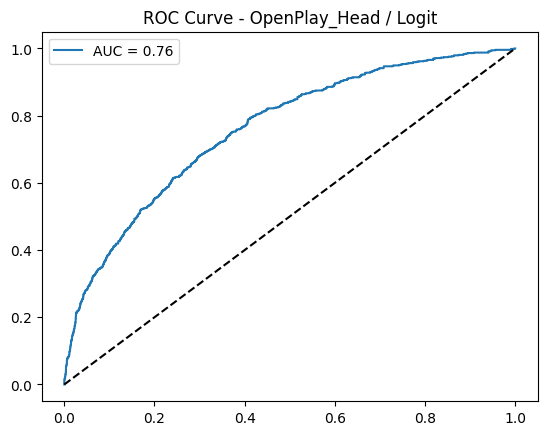

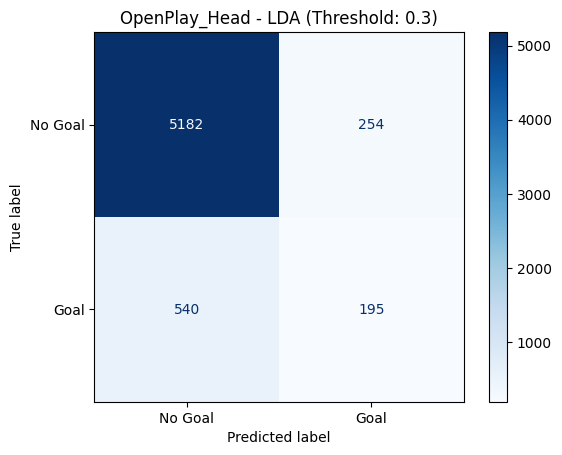

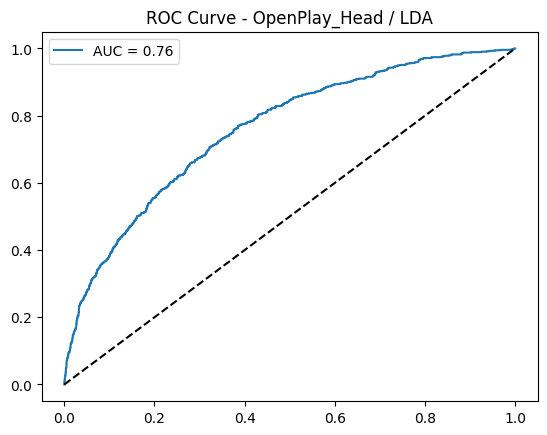

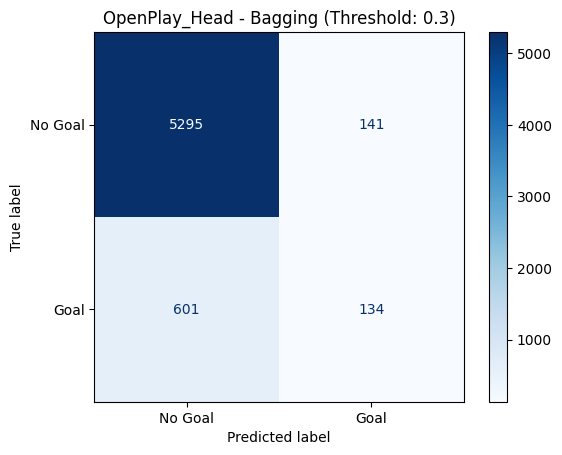

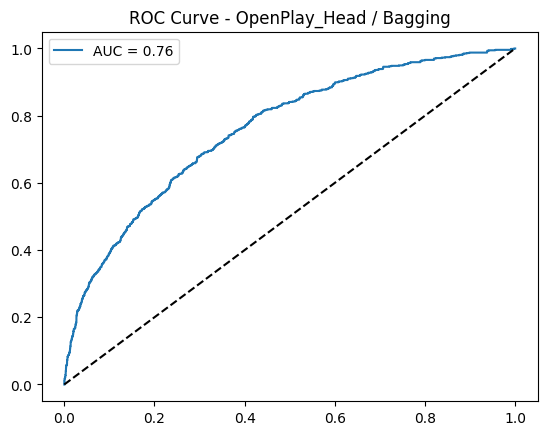

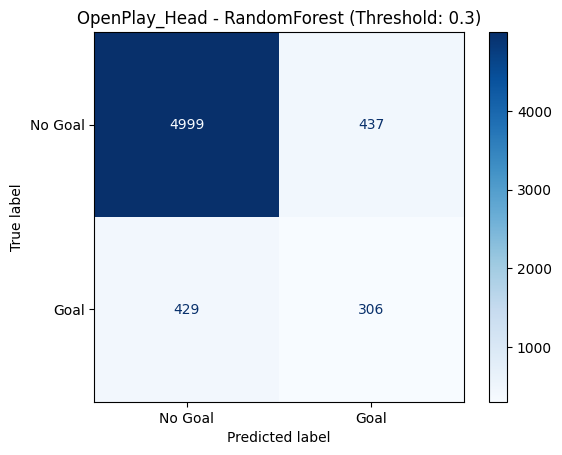

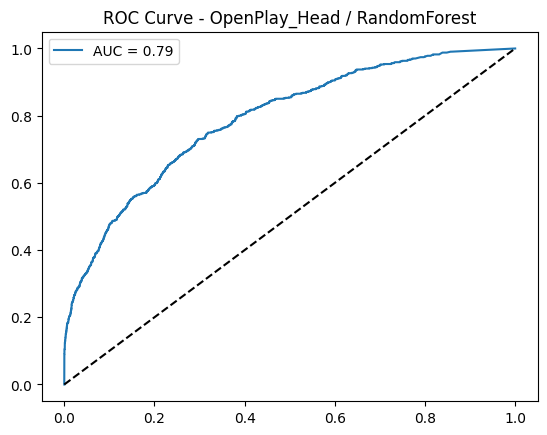

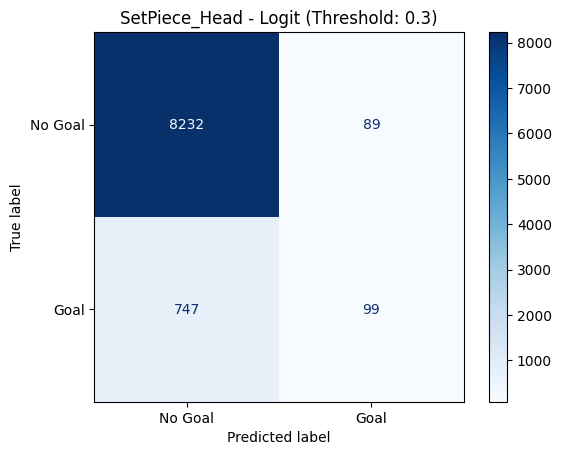

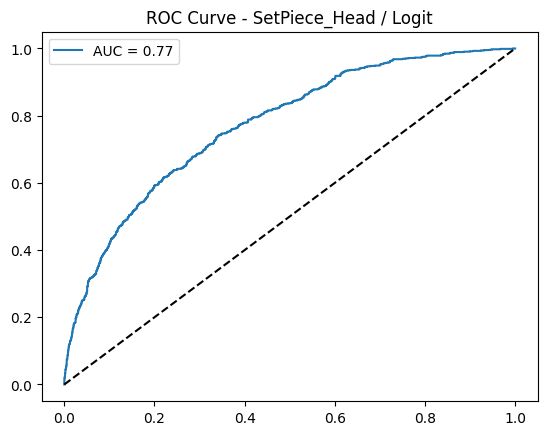

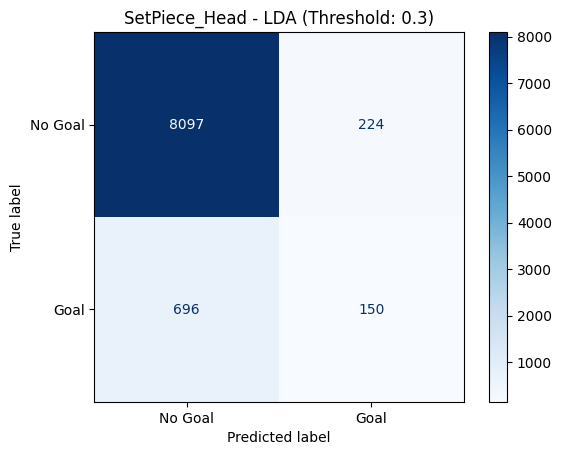

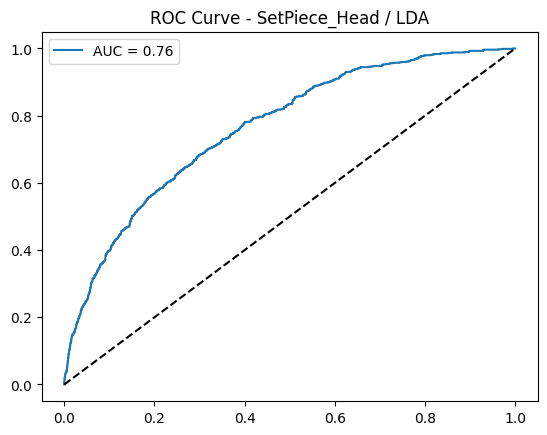

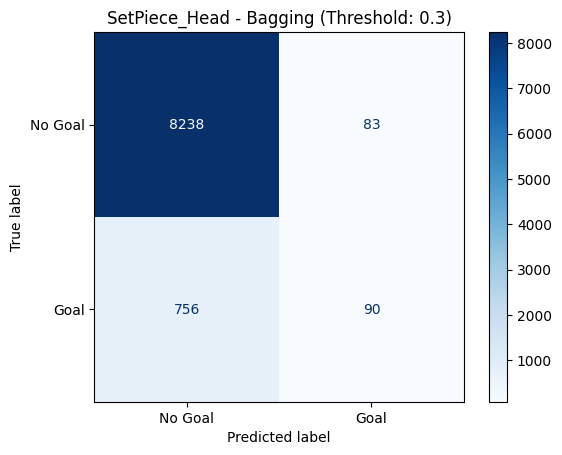

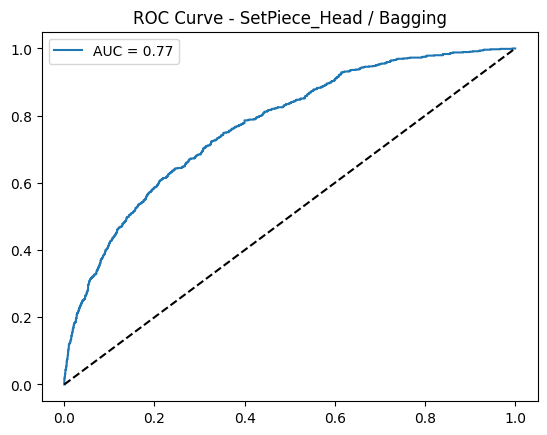

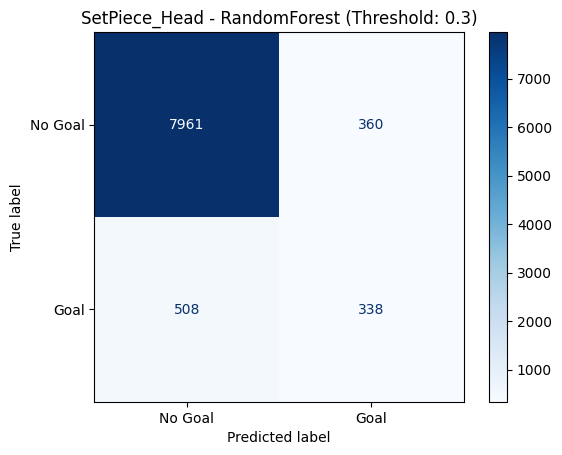

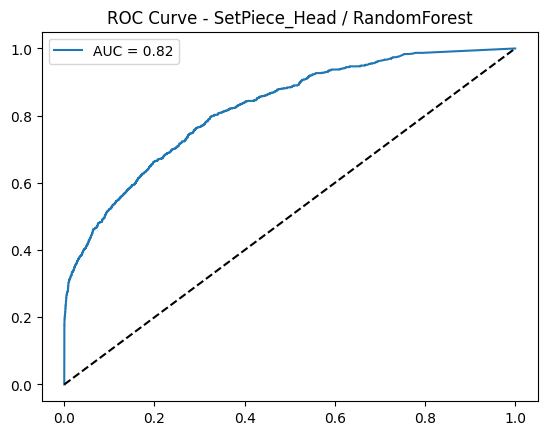

In [17]:
def evaluate_models(results, threshold=0.3, save_dir='plots'):
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score, f1_score
    from sklearn.calibration import calibration_curve

    os.makedirs(save_dir, exist_ok=True)

    for dataset_name, models in results.items():
        for model_name, metrics in models.items():
            if 'y_test' in metrics and 'y_proba' in metrics:
                y_test = np.array(metrics['y_test'])
                y_proba = np.array(metrics['y_proba'])
                y_pred = (y_proba >= threshold).astype(int)

                # Confusion matrix
                cm = confusion_matrix(y_test, y_pred)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Goal', 'Goal'])
                disp.plot(cmap=plt.cm.Blues)
                plt.title(f"{dataset_name} - {model_name} (Threshold: {threshold})")
                plt.grid(False)
                plt.savefig(f"{save_dir}/conf_matrix_{dataset_name}_{model_name}.png")
                plt.show()

                # ROC
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                roc_auc = auc(fpr, tpr)
                plt.figure()
                plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
                plt.plot([0, 1], [0, 1], 'k--')
                plt.title(f"ROC Curve - {dataset_name} / {model_name}")
                plt.legend()
                plt.savefig(f"{save_dir}/roc_curve_{dataset_name}_{model_name}.png")
                plt.show()



evaluate_models(results, threshold=0.3)

## Neurla Network

Model used:
Feed Forward Dense Sequential neural network with:
128 than 64 neurons, relu activation function, and dropout rate of 30%
Final knot with sigmoid activation function

In [19]:
def train_nn_on_dataset(df, dataset_name, use_weakfoot=True):
    df = df.copy()
    df['goal'] = (df['result'] == 1).astype(int)

    features = ['minute', 'lastAction', 'h_a', 'X', 'Y']
    if use_weakfoot:
        features.append('is_weakfoot')

    X = df[features]
    y = df['goal']

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42)

    categorical_features = ['lastAction', 'h_a']
    if use_weakfoot:
        categorical_features.append('is_weakfoot')
    numeric_features = ['minute', 'X', 'Y']

    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, categorical_features)
    ], remainder='passthrough')

    preprocessor.fit(pd.concat([X_train, X_val, X_test]))
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    X_test_proc = preprocessor.transform(X_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_proc)
    X_val_scaled = scaler.transform(X_val_proc)
    X_test_scaled = scaler.transform(X_test_proc)

    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f"Training Loss - {dataset_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"training_curve_nn_{dataset_name}.png")
    plt.show()

    y_proba = model.predict(X_test_scaled).ravel()
    y_pred = (y_proba >= 0.3).astype(int)

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=['No Goal', 'Goal'],
        cmap=plt.cm.Blues,
        include_values=True,
        values_format='d'
    )
    disp.ax_.set_title(f"Confusion Matrix - {dataset_name} (Threshold 0.3)")
    plt.tight_layout()
    plt.savefig(f"conf_matrix_nn_{dataset_name}.png")
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{dataset_name}")
    print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall (Sensitivity): {recall_score(y_test, y_pred):.2f}")
    print(f"Specificity: {tn / (tn + fp):.2f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.2f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"roc_curve_nn_{dataset_name}.png")
    plt.show()

    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Frequency")
    plt.title(f"Calibration Plot - {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"calibration_nn_{dataset_name}.png")
    plt.show()
    return model, X_test_scaled, preprocessor



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
I0000 00:00:1753113459.473501      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1753113462.686631     127 service.cc:148] XLA service 0x78a2f8009e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753113462.687246     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753113462.994659     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


  67/2709 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6917 - auc: 0.5142 - loss: 0.5717

I0000 00:00:1753113464.542266     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2709/2709 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8904 - auc: 0.7190 - loss: 0.3094 - val_accuracy: 0.9036 - val_auc: 0.7891 - val_loss: 0.2707
Epoch 2/50
2709/2709 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9032 - auc: 0.7748 - loss: 0.2756 - val_accuracy: 0.9056 - val_auc: 0.7907 - val_loss: 0.2688
Epoch 3/50
2709/2709 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9043 - auc: 0.7807 - loss: 0.2739 - val_accuracy: 0.9048 - val_auc: 0.7936 - val_loss: 0.2683
Epoch 4/50
2709/2709 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9040 - auc: 0.7836 - loss: 0.2729 - val_accuracy: 0.9056 - val_auc: 0.7933 - val_loss: 0.2669
Epoch 5/50
2709/2709 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9043 - auc: 0.7866 - loss: 0.2715 - val_accuracy: 0.9057 - val_auc: 0.7934 - val_loss: 0.2675
Epoch 6/50
2709/2709 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9044 - auc: 0.7846 - loss: 0.2716 - val_accuracy: 0.9059 - val_auc: 0.7945 - val_loss: 0.2660
Epoch 7/50
2709/2709 ━━━━━━━━━━━━━━━━━

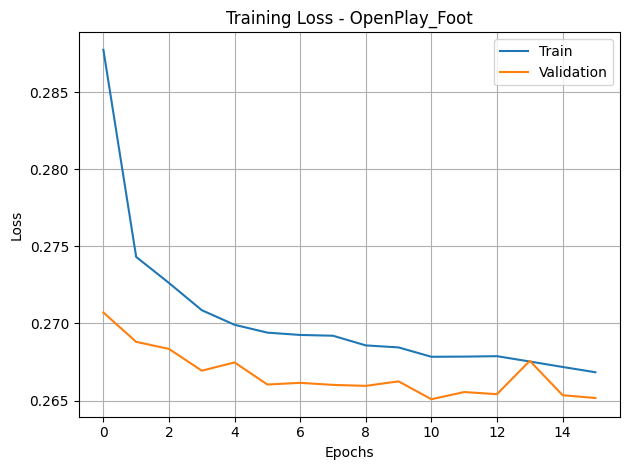

1806/1806 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


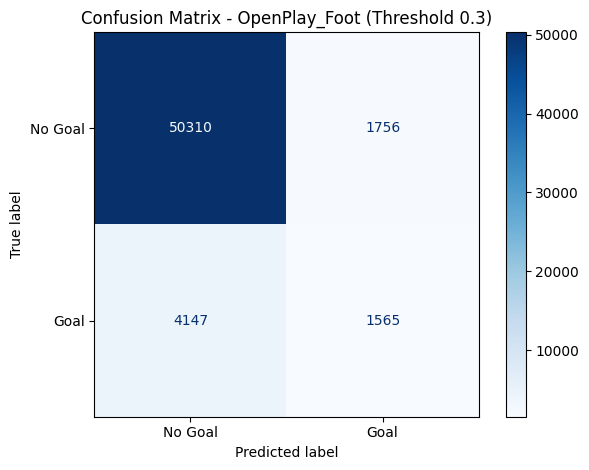


OpenPlay_Foot
TP: 1565, FP: 1756, FN: 4147, TN: 50310
Precision: 0.47
Recall (Sensitivity): 0.27
Specificity: 0.97
F1-score: 0.35


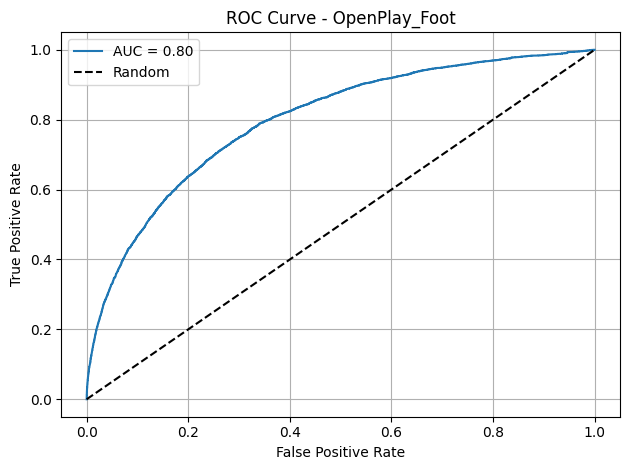

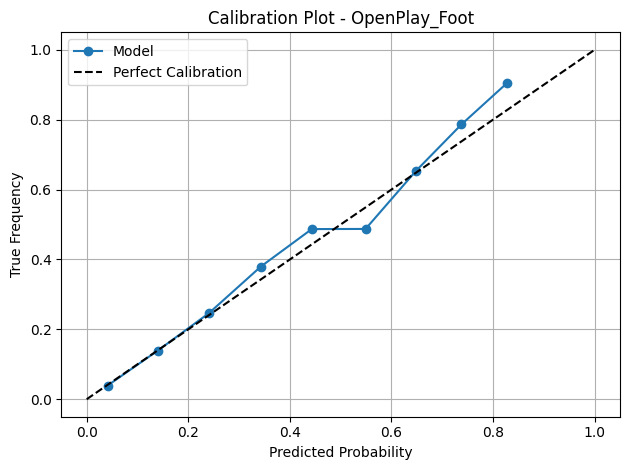

Epoch 1/50


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


652/652 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9021 - auc: 0.6301 - loss: 0.3040 - val_accuracy: 0.9224 - val_auc: 0.7432 - val_loss: 0.2378
Epoch 2/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9224 - auc: 0.7366 - loss: 0.2454 - val_accuracy: 0.9244 - val_auc: 0.7455 - val_loss: 0.2369
Epoch 3/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9240 - auc: 0.7532 - loss: 0.2366 - val_accuracy: 0.9228 - val_auc: 0.7461 - val_loss: 0.2360
Epoch 4/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9269 - auc: 0.7568 - loss: 0.2303 - val_accuracy: 0.9248 - val_auc: 0.7505 - val_loss: 0.2313
Epoch 5/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9270 - auc: 0.7491 - loss: 0.2323 - val_accuracy: 0.9266 - val_auc: 0.7516 - val_loss: 0.2339
Epoch 6/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9254 - auc: 0.7562 - loss: 0.2323 - val_accuracy: 0.9276 - val_auc: 0.7561 - val_loss: 0.2289
Epoch 7/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

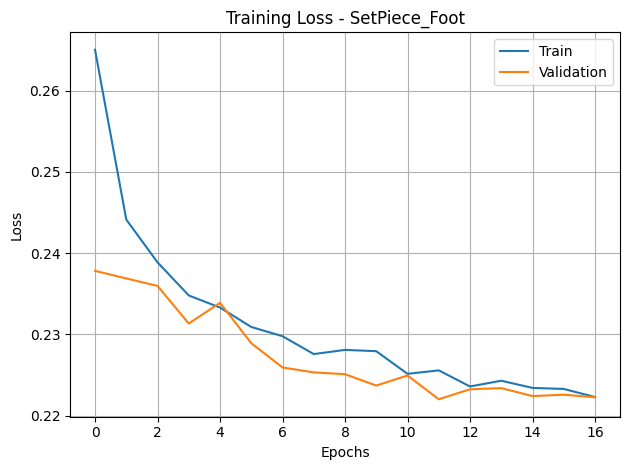

435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


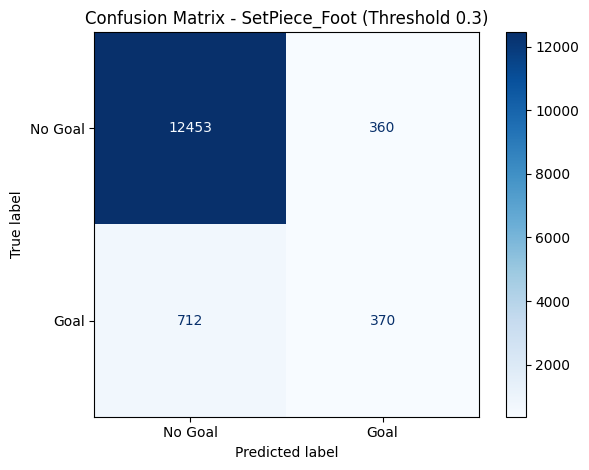


SetPiece_Foot
TP: 370, FP: 360, FN: 712, TN: 12453
Precision: 0.51
Recall (Sensitivity): 0.34
Specificity: 0.97
F1-score: 0.41


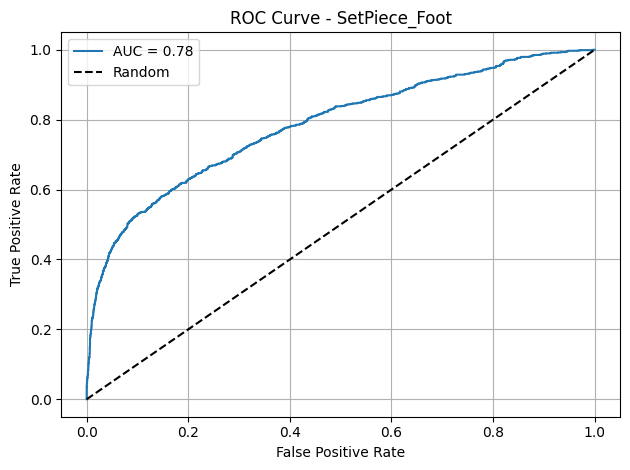

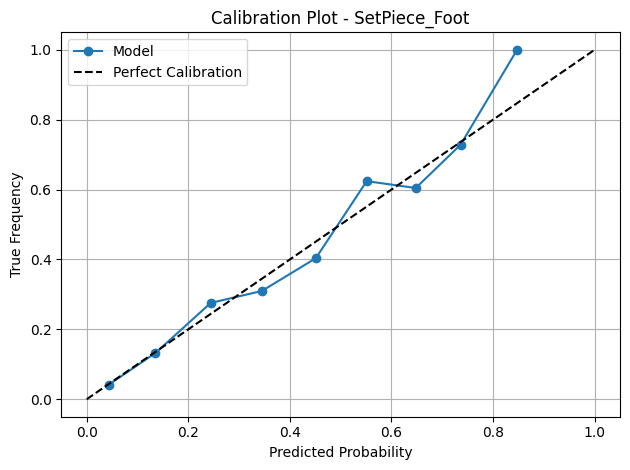

Epoch 1/50


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


290/290 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8717 - auc: 0.6330 - loss: 0.3888 - val_accuracy: 0.8812 - val_auc: 0.7622 - val_loss: 0.3198
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8813 - auc: 0.7397 - loss: 0.3285 - val_accuracy: 0.8819 - val_auc: 0.7685 - val_loss: 0.3170
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8823 - auc: 0.7489 - loss: 0.3219 - val_accuracy: 0.8817 - val_auc: 0.7775 - val_loss: 0.3132
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8871 - auc: 0.7505 - loss: 0.3150 - val_accuracy: 0.8833 - val_auc: 0.7732 - val_loss: 0.3142
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8838 - auc: 0.7662 - loss: 0.3140 - val_accuracy: 0.8841 - val_auc: 0.7755 - val_loss: 0.3122
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8844 - auc: 0.7599 - loss: 0.3137 - val_accuracy: 0.8838 - val_auc: 0.7794 - val_loss: 0.3113
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

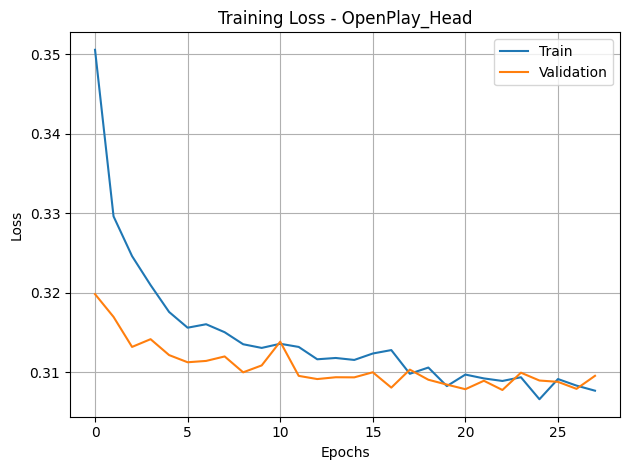

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


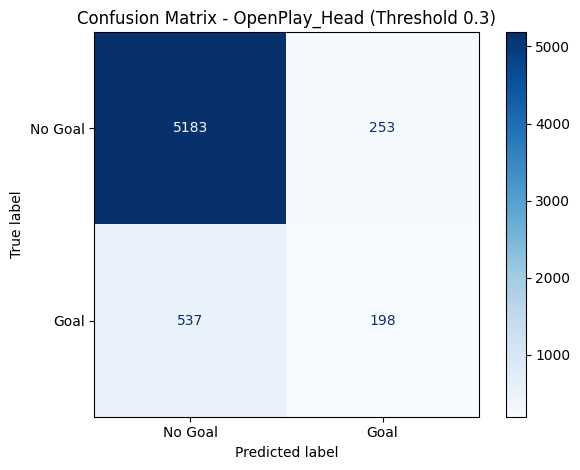


OpenPlay_Head
TP: 198, FP: 253, FN: 537, TN: 5183
Precision: 0.44
Recall (Sensitivity): 0.27
Specificity: 0.95
F1-score: 0.33


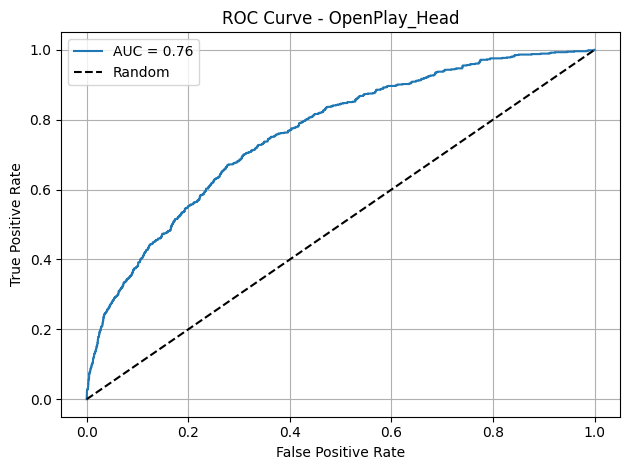

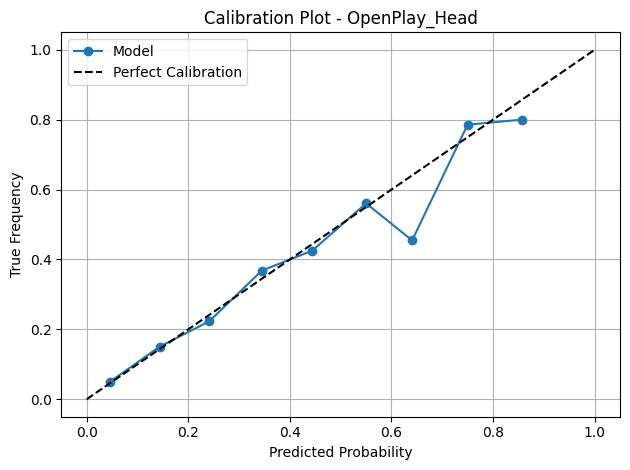

Epoch 1/50


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8872 - auc: 0.6139 - loss: 0.3492 - val_accuracy: 0.9077 - val_auc: 0.7504 - val_loss: 0.2747
Epoch 2/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9108 - auc: 0.7389 - loss: 0.2710 - val_accuracy: 0.9079 - val_auc: 0.7585 - val_loss: 0.2720
Epoch 3/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9075 - auc: 0.7367 - loss: 0.2780 - val_accuracy: 0.9075 - val_auc: 0.7603 - val_loss: 0.2710
Epoch 4/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9104 - auc: 0.7485 - loss: 0.2679 - val_accuracy: 0.9075 - val_auc: 0.7608 - val_loss: 0.2712
Epoch 5/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9077 - auc: 0.7473 - loss: 0.2742 - val_accuracy: 0.9078 - val_auc: 0.7596 - val_loss: 0.2706
Epoch 6/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9052 - auc: 0.7684 - loss: 0.2713 - val_accuracy: 0.9083 - val_auc: 0.7631 - val_loss: 0.2695
Epoch 7/50
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

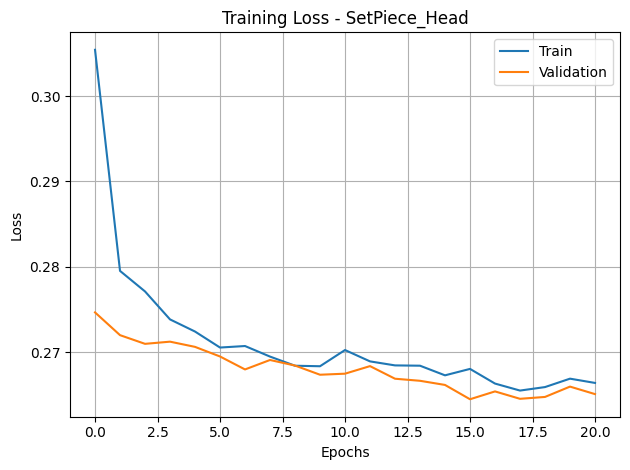

287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


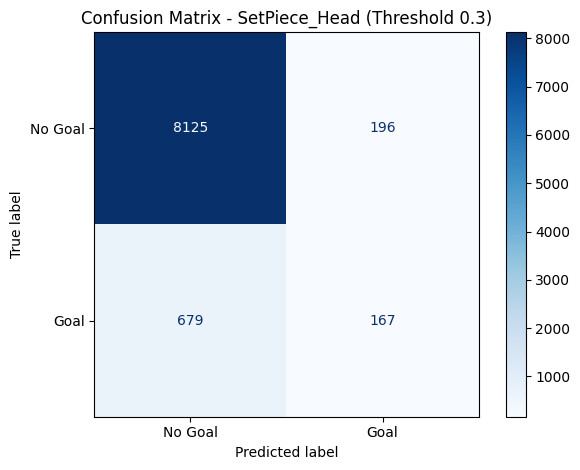


SetPiece_Head
TP: 167, FP: 196, FN: 679, TN: 8125
Precision: 0.46
Recall (Sensitivity): 0.20
Specificity: 0.98
F1-score: 0.28


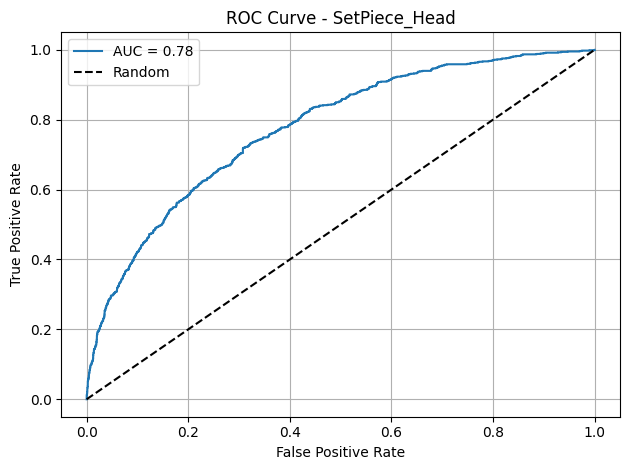

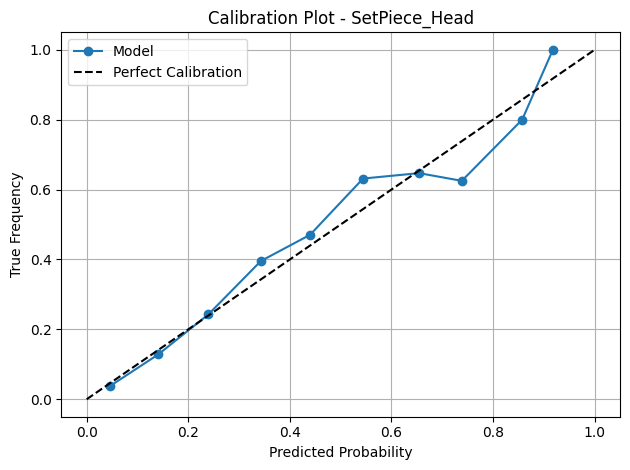

In [20]:
models = {}
Xtests = {}
preprocessors = {}

datasets = [
    ('OpenPlay_Foot', open_play_foot, True),
    ('SetPiece_Foot', set_piece_foot, True),
    ('OpenPlay_Head', open_play_head, False),
    ('SetPiece_Head', set_piece_head, False),
]

for name, df, use_weakfoot in datasets:
    model, X_test_scaled, preprocessor = train_nn_on_dataset(df, name, use_weakfoot)
    models[name] = model
    Xtests[name] = X_test_scaled
    preprocessors[name] = preprocessor



SHAP analysis for: OpenPlay_Foot


PermutationExplainer explainer: 2501it [03:04, 12.81it/s]                          


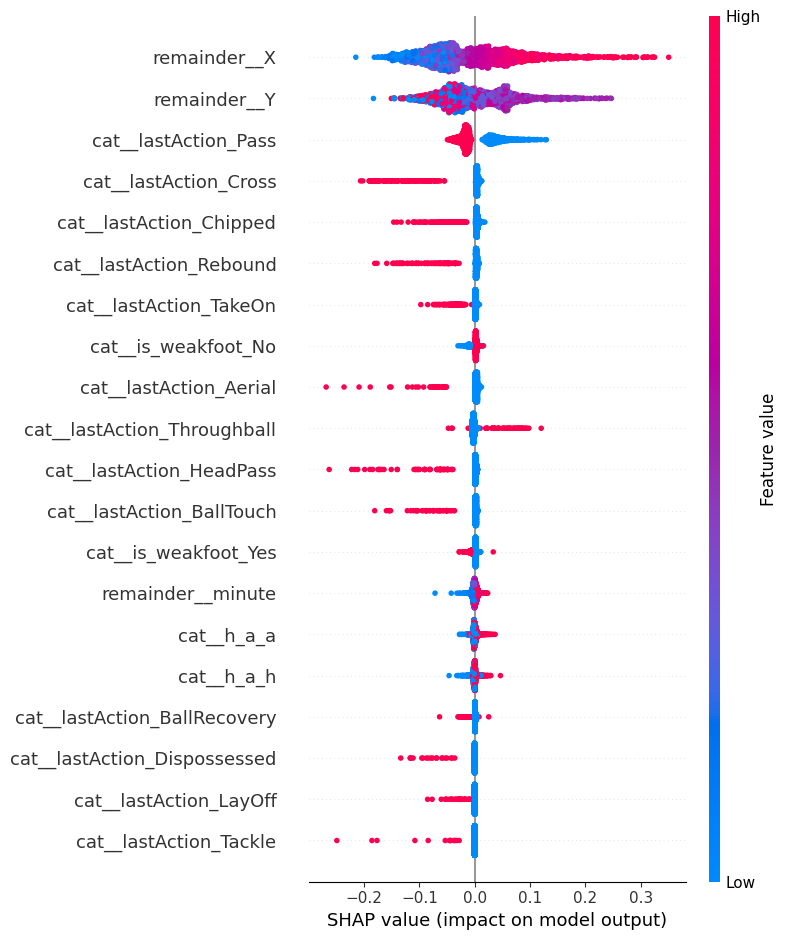

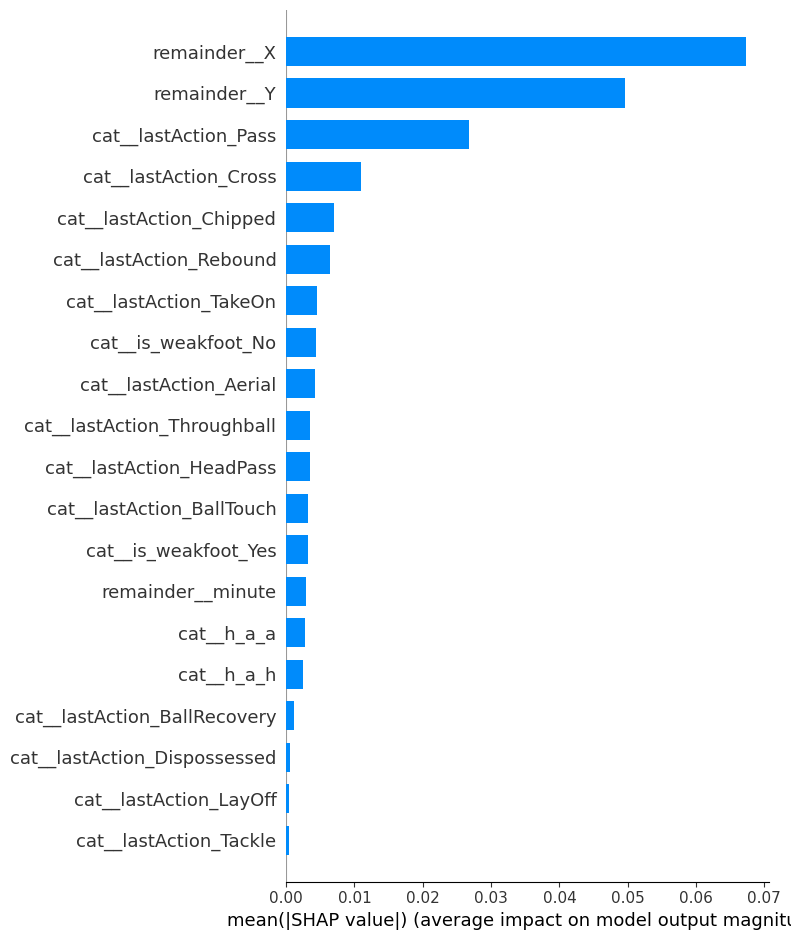


SHAP analysis for: SetPiece_Foot


PermutationExplainer explainer: 2501it [03:14, 12.23it/s]                          


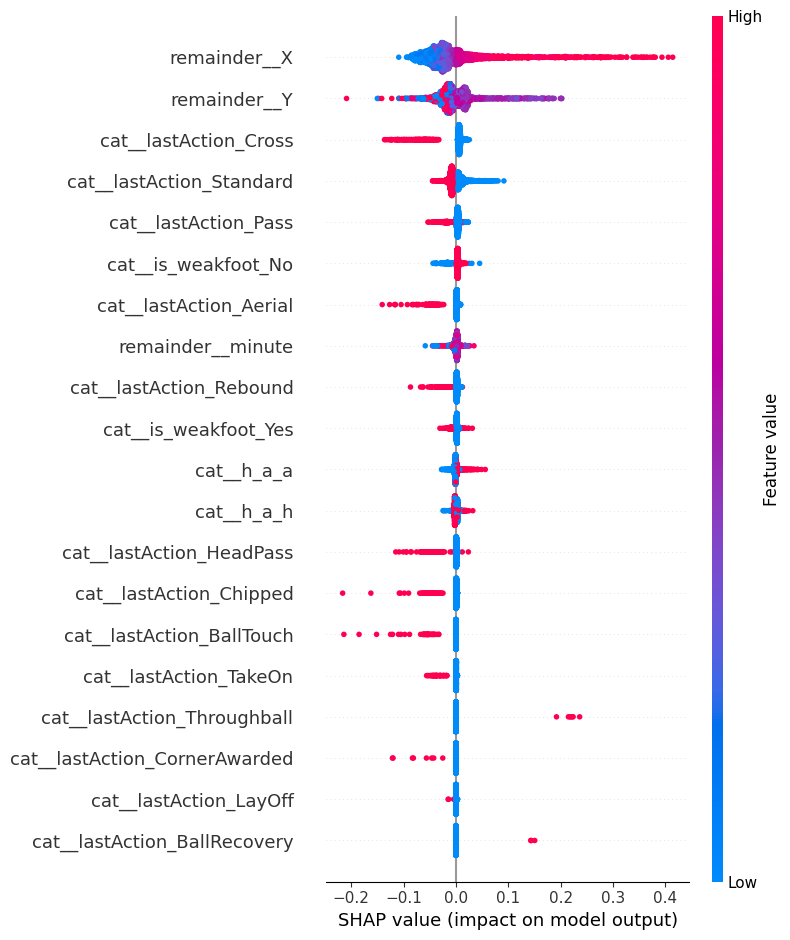

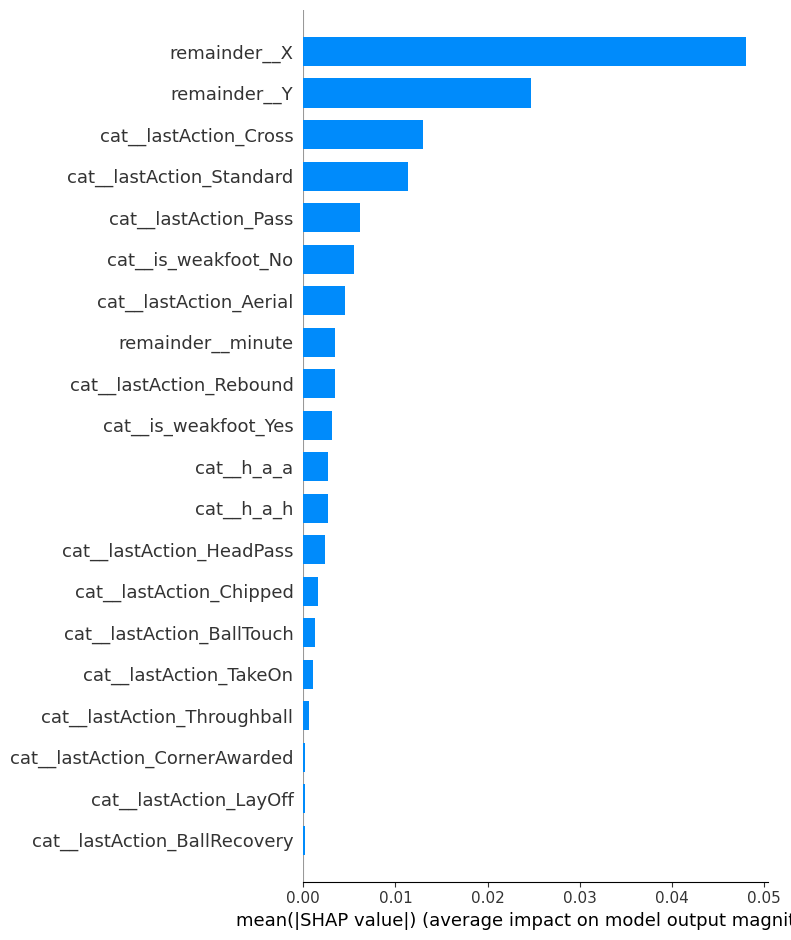


SHAP analysis for: OpenPlay_Head


PermutationExplainer explainer: 2501it [04:21,  9.20it/s]                          


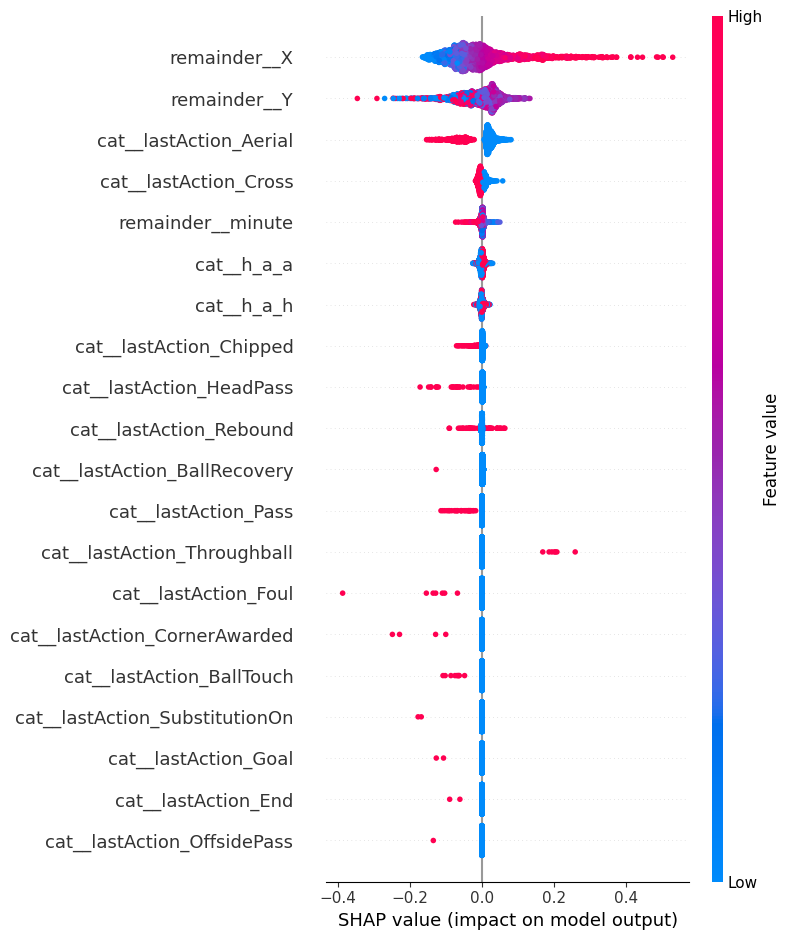

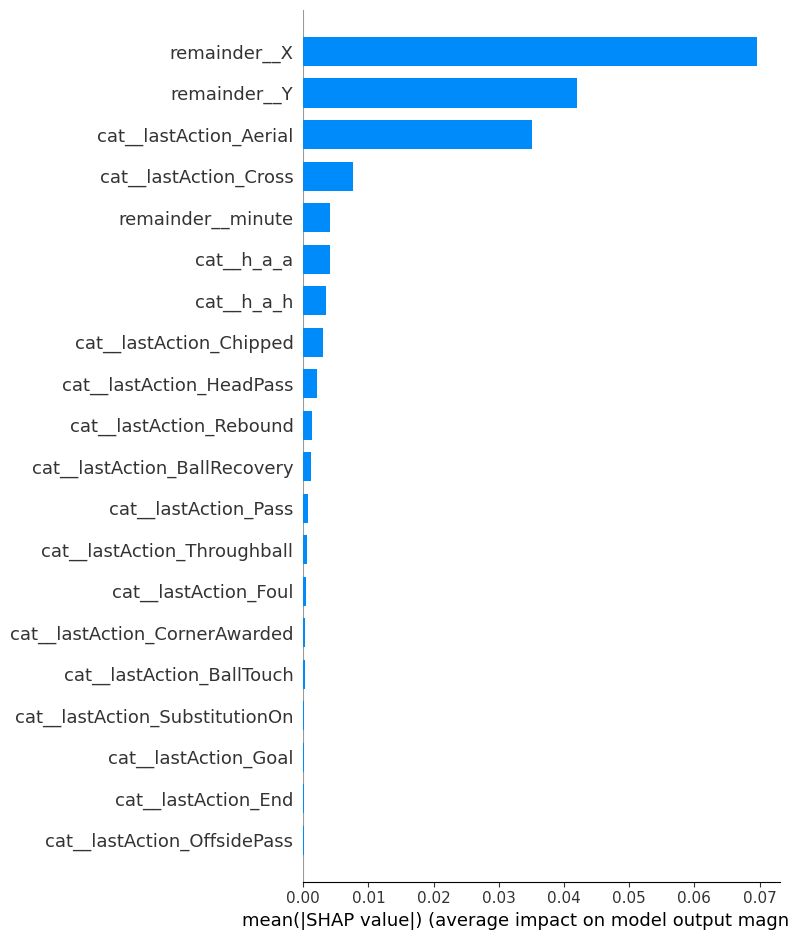


SHAP analysis for: SetPiece_Head


PermutationExplainer explainer: 2501it [04:23,  9.15it/s]                          


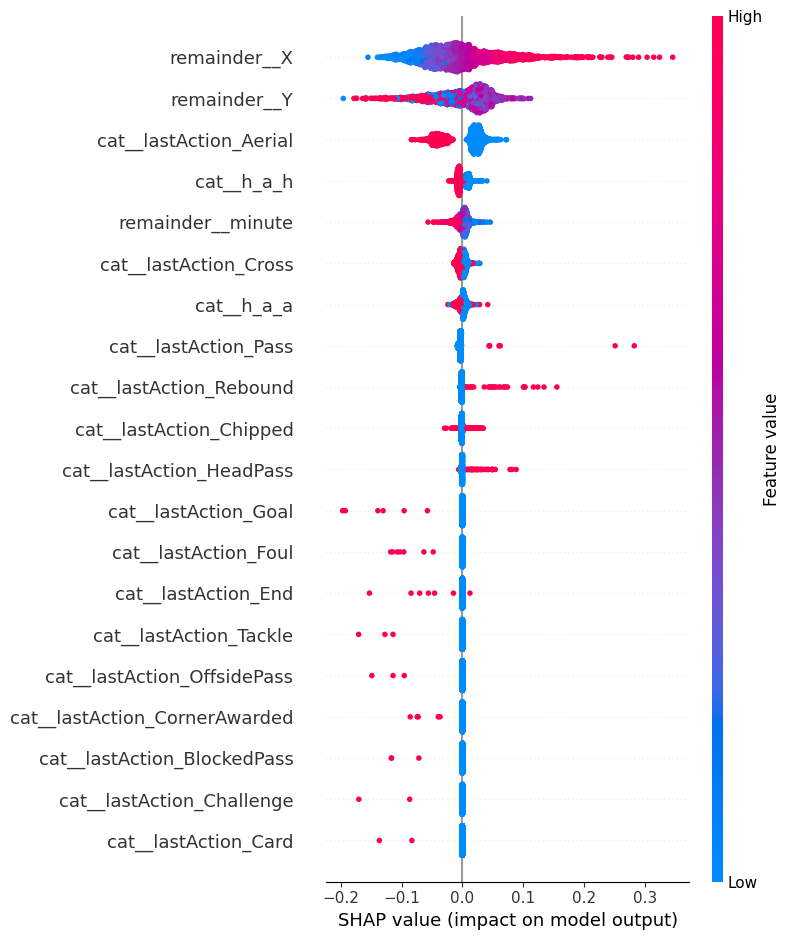

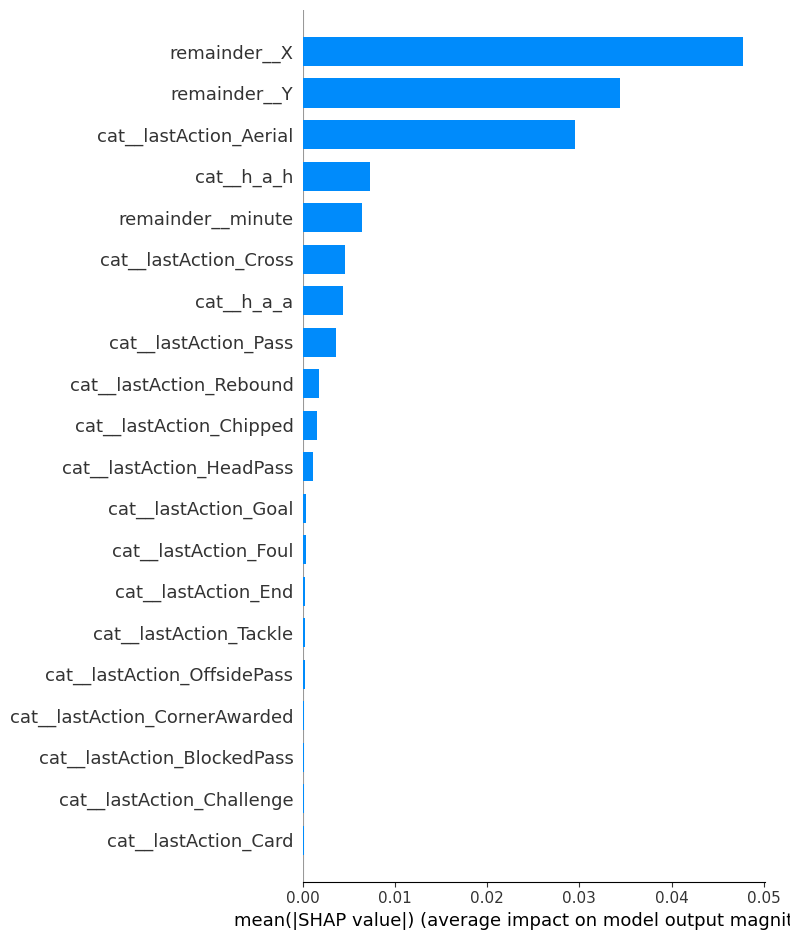

In [22]:
for name in models:
    model = models[name]
    X_test_scaled = Xtests[name]
    preprocessor = preprocessors[name]

    print(f"\nSHAP analysis for: {name}")

    # === campione per SHAP ===
    X_shap = X_test_scaled[:2500]
    background = X_test_scaled[np.random.choice(X_test_scaled.shape[0], 100, replace=False)]

    # === nomi feature
    feature_names = preprocessor.get_feature_names_out()

    # === SHAP
    explainer = shap.Explainer(model, background)
    shap_values = explainer(X_shap)

    # === summary plot
    shap.summary_plot(shap_values, features=X_shap, feature_names=feature_names, show=True)

    # === bar plot
    shap.summary_plot(shap_values, features=X_shap, feature_names=feature_names, plot_type='bar', show=True)
